In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("../input/bike-sharing-demand/train.csv", parse_dates=["datetime"])
df_test = pd.read_csv("../input/bike-sharing-demand/test.csv", parse_dates=["datetime"])

print(df_train.shape)
print(df_test.shape)

(10886, 12)
(6493, 9)


# Feature Engineering

- 앞에서 year, month, hour, weekday가 유의미한 feature인 것을 확인함

In [3]:
df_train["year"] = df_train["datetime"].dt.year
df_train["month"] = df_train["datetime"].dt.month
df_train["hour"] = df_train["datetime"].dt.hour
df_train["weekday"] = df_train["datetime"].dt.dayofweek

df_train.shape

(10886, 16)

In [4]:
df_test["year"] = df_test["datetime"].dt.year
df_test["month"] = df_test["datetime"].dt.month
df_test["hour"] = df_test["datetime"].dt.hour
df_test["weekday"] = df_test["datetime"].dt.dayofweek

df_test.shape

(6493, 13)

In [5]:
from sklearn.ensemble import RandomForestRegressor

rfModel_wind = RandomForestRegressor()

f_columns = ["season", "weather", "humidity", "month", "temp",
             "year", "hour", "weekday", "atemp"]

# 특정 열을 train 데이터에 추가
X_train = df_train[f_columns]
y_r_label = df_train["registered"]
y_c_label = df_train["casual"]

print(X_train.shape)
print(y_r_label.shape)
print(y_c_label.shape)

(10886, 9)
(10886,)
(10886,)


In [6]:
# 마찬가지로 test 데이터에도 추가
X_test = df_test[f_columns]
X_test.shape

(6493, 9)

In [7]:
# train 데이터와 register 데이터 훈련시킴

rfModel = RandomForestRegressor()
rfModel.fit(X_train, y_r_label)

RandomForestRegressor()

In [8]:
# 훈련시킨 값으로 test 데이터 예측하기

testRegisteredValues = rfModel.predict(X_test)

In [9]:
# 예측한 값 넣어주기

df_test["registered"] = testRegisteredValues
df_test["registered"].isnull().sum()

0

In [10]:
# train 데이터와 casual 데이터 훈련시킴

rfModel.fit(X_train, y_c_label)

RandomForestRegressor()

In [11]:
# 마찬가지로 똑같이 예측하고 값 넣어주기

testCasualValues = rfModel.predict(X_test)

df_test["casual"] = testCasualValues
df_test["casual"].isnull().sum()

0

### 이해가 안 가 ,,,,

<AxesSubplot:xlabel='hour', ylabel='value'>

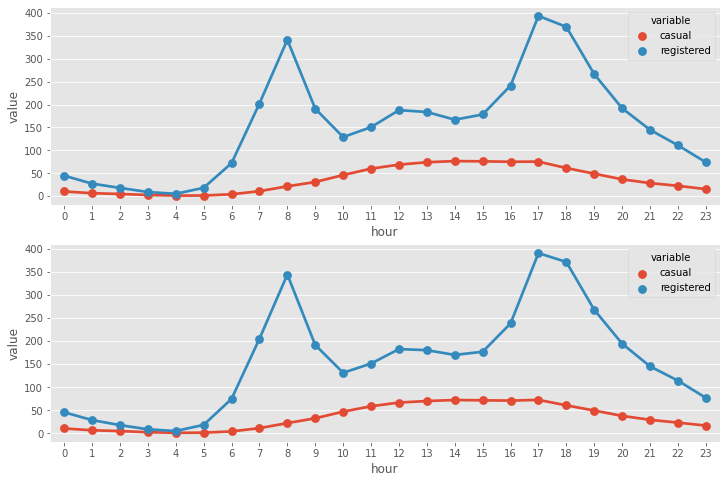

In [12]:
fig,(ax1,ax2)= plt.subplots(nrows=2, figsize=(12, 8))

hourTransformed = pd.melt(
    df_train[['hour','casual','registered']], 
    id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(
    hourTransformed.groupby(['hour','variable'], 
                            sort=True)['value'].mean()).reset_index()
sns.pointplot(x=hourAggregated['hour'], 
              y=hourAggregated['value'],
              hue=hourAggregated['variable'],
              hue_order=['casual','registered'],
              data=hourAggregated, join=True, ax=ax1)


hourTransformed = pd.melt(
    df_test[['hour','casual','registered']], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(
    hourTransformed.groupby(['hour','variable'],
                            sort=True)['value'].mean()).reset_index()
sns.pointplot(x=hourAggregated['hour'],
              y=hourAggregated['value'],
              hue=hourAggregated['variable'],
              hue_order=['casual','registered'],
              data=hourAggregated, join=True, ax=ax2)



- registered 데이터가 hour와 관련이 있다..?!

#### train과 test 데이터셋 합쳐주기

In [13]:
data = df_train.append(df_test)
data.reset_index(inplace=True)
data.drop("index", inplace=True, axis=1)

#### 풍속=0 인 데이터 값 보정해주기

In [14]:
# 풍속이 0이 아닌 값들로 0인 값을 예측할 것임
dataWind0 = data[data["windspeed"] == 0] # test set
dataWindNot0 = data[data["windspeed"] != 0] # train set

rfModel_wind = RandomForestRegressor()

# 풍속을 예측할 feature
windColumns = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

# 위 feature 값들을 바탕으로 풍속 학습시킴
rfModel_wind.fit(dataWindNot0[windColumns], dataWindNot0["windspeed"])

# 학습한 값 바탕으로 풍속=0인 데이터의 풍속 예측
wind0Values = rfModel_wind.predict(X=dataWind0[windColumns])

# 값이 0으로 기록된 풍속에 예측한 값 넣어주기
dataWind0["windspeed"] = wind0Values

# 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임 합쳐주기
data = dataWindNot0.append(dataWind0)

data.reset_index(inplace=True)
data.drop("index", inplace=True, axis=1)

$$
\sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$

In [15]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values, convertExp=True):
    
    if convertExp:
        predicted_values = np.exp(predicted_values)
        actual_values = np.exp(actual_values)
    
    # 넘파이로 배열 형태 바꿔주기
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값, 실제값에 +1 하고 로그 씌우기
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # (예측값 - 실제값) 제곱
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    # 평균내기
    mean_difference = difference.mean()
    
    # 루트 씌우기
    score = np.sqrt(mean_difference)
    
    return score

In [16]:
categoricalFeatureNames = ["season", "holiday", "workingday",
                          "weather", "weekday", "year", "hour"]

numericalFeatureNames = ["temp", "humidity", "windspeed", "atemp",
                        "casual", "registered"]

dropFeatures = ["count", "datetime", "month"]

In [17]:
# 카테고리로 데이터 형변환

for var in categoricalFeatureNames:
    data[var] = data[var].astype("category")

- 이거 무슨 말이뉘..

In [18]:
X_train = data[pd.notnull(data["count"])].sort_values(by=["datetime"])
X_test = data[~pd.notnull(data["count"])].sort_values(by=["datetime"])

datetimecol = X_test["datetime"]
y_train = X_train["count"]

In [19]:
X_train = X_train.drop(dropFeatures, axis=1)
X_test = X_test.drop(dropFeatures, axis=1)

- 무슨 말..

In [20]:
rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
rfModel.fit(X_train, y_train_log)

RandomForestRegressor()

In [21]:
preds = rfModel.predict(X_train)
score = rmsle(np.exp(y_train_log), np.exp(preds), False)
print("RMSLE Value for Random Forest: ", score)

RMSLE Value for Random Forest:  0.005003786861771978


<AxesSubplot:ylabel='Density'>

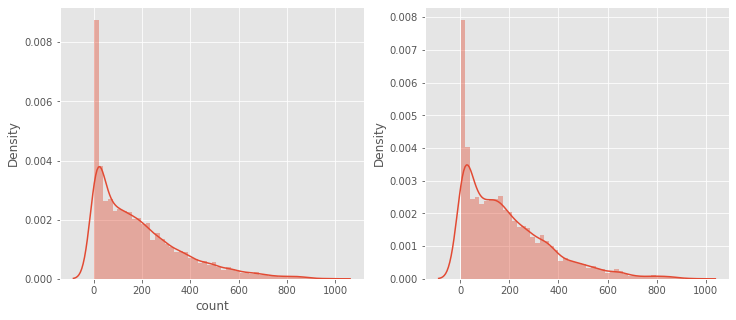

In [22]:
predsTest = rfModel.predict(X_test)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
sns.distplot(y_train, ax=ax1, bins=50)
sns.distplot(np.exp(predsTest), ax=ax2, bins=50)

In [23]:
submission = pd.read_csv("../input/bike-sharing-demand/sampleSubmission.csv")
submission

submission["count"] = np.exp(predsTest)

print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,14.019331
1,2011-01-20 01:00:00,7.000000
2,2011-01-20 02:00:00,5.000000
3,2011-01-20 03:00:00,4.000000
4,2011-01-20 04:00:00,3.000000


In [24]:
submission.to_csv("Score_{0:.5f}_submission.csv".format(score), index=False)